This project attempts to create a model to create monet style images using a photo as an input. We will be using a GNN model to attempt this task.

The purpose of this project will be to further my understanding of adversarial machine learning models as well to attempt a high score on the kaggle competition mentioned below.

All data for this project is found from here: https://www.kaggle.com/competitions/gan-getting-started

The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
photo_jpg - 7028 photos sized 256x256 in JPEG format
photo_tfrec - 7028 photos sized 256x256 in TFRecord format

In [73]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import os

EDA

Some basic exploratory EDA. We check the size of all images to ensure they're all the same size and also to check the size of the dataset. We then load and view some sample images to get a sense for what they look like. The images are high quality.

This dataset is very clean and no further cleaning is necessary. 

In [18]:
monet_dir = 'gan-getting-started/monet_jpg'
photo_dir = 'gan-getting-started/photo_jpg'

def explore_images(directory):
    sizes = {}
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):  # assuming images are in jpg format
            with Image.open(os.path.join(directory, filename)) as img:
                size = img.size
                if size in sizes:
                    sizes[size] += 1
                else:
                    sizes[size] = 1
    return sizes

monet_sizes = explore_images(monet_dir)
photo_sizes = explore_images(photo_dir)

# check the size of images in case we need to clean it
# also check for number of images
print("Monet image sizes and their counts:", monet_sizes)
print("Photo image sizes and their counts:", photo_sizes)

Monet image sizes and their counts: {(256, 256): 300}
Photo image sizes and their counts: {(256, 256): 7038}


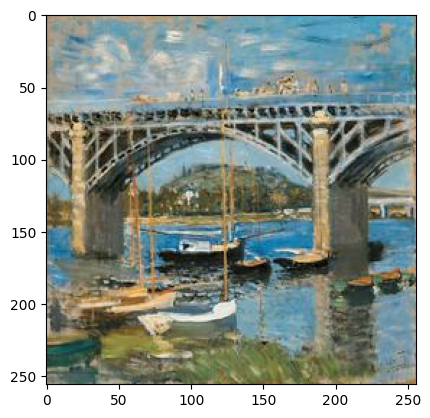

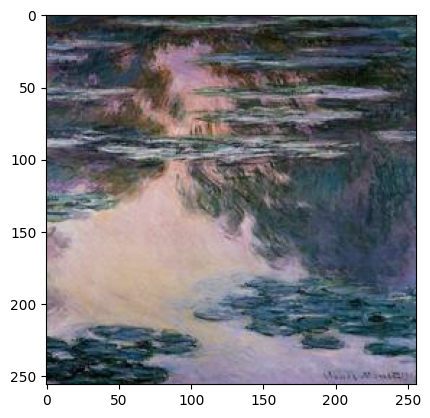

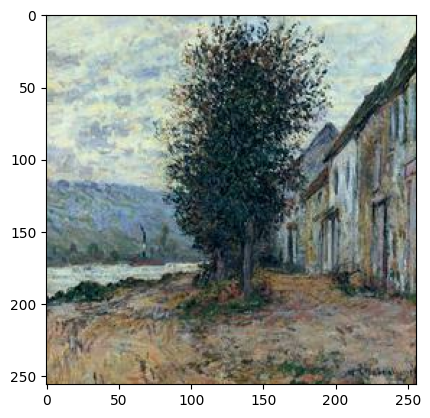

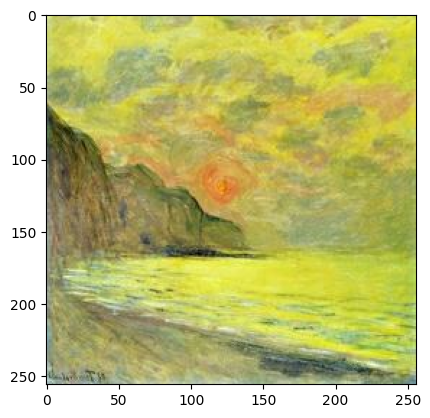

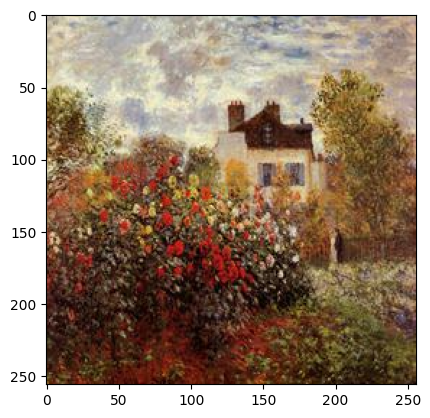

2024-05-03 00:57:43.981838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [36]:
def load_images(directory, size=(256, 256)):
    """
    Load and preprocess images from a directory using TensorFlow.
    :param directory: Path to the image directory.
    :param size: Size to resize the images.
    :return: A TensorFlow dataset of processed images.
    """
    def decode_img(img):
        # Convert the compressed string to a 3D uint8 tensor
        img = tf.image.decode_jpeg(img, channels=3)
        # Resize the image to the specified size
        return tf.image.resize(img, size)
    
    def process_path(file_path):
        # Load the raw data from the file as a string
        img = tf.io.read_file(file_path)
        img = decode_img(img)
        return img / 255.0  # Normalize to [0, 1]

    list_ds = tf.data.Dataset.list_files(directory + '/*.jpg', shuffle=True)
    images_ds = list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    return images_ds

monet_images = load_images(monet_dir)
photo_images = load_images(photo_dir)

# view some images
for image in monet_images.take(5):
    plt.imshow(image)
    plt.show()

Model Architecture

The model we will be building will be a GAN model that uses many convolution layers. A GAN model typically has two models: a generator and a discriminator.

The generator will be trained to create new fake images based on an input and the discriminator will guess whether or not an image is fake or not. Through a programmatic approach, we will optimize the generator and discriminator models so that they get smarter and eventually the generator model will be able to generate good monet style images.

The generator model will downsample and the upsample the input. The downsampling will involve several convolution layers with increasing filters with a relu activation and a random initializer. We increase the number of filters so that the model can slowly view more and more features of the image. This helps models better understand the image. We add batch normalization layers to stabilize the training which is essential in deeper models like this. The upsampling does the reverse and tries to rebuild an image based on all the key features extracted from downsampling. It gradually upscales the features back to the original image dimension and reconstructs an image. This is done with convolultion 2d transpose layers with decreasing filters. Similarly to upsampling, we use batch normalization to stabilize the training. The final layer in the generator is a convolution 2d transpose layer with 3 filters and a tanh activation function to generate an image in RGB.

The discriminator model does something similar to the generator model. It uses a series of convolution layers with increasing number of filters to slowly process more and more complex features of the image. We use leaky relu as the activation function to introduce non linearity and to maintain the gradient flow through the networks. We add dropout layers as a regularization technique to randomly set inputs to 0 at each update which prevents overfitting of the model. The final convolution 2D layer has 1 filter because we want to it to classify whether its 0 a fake image or 1 a real image.

The model is optimized by calculating the loss for the generator model and the discriminator model and feeding it back to the cycle and reran using better weights.

I chose this architecture because this follows a typical U-Net architecture for processing images. A series of increasing filters of convolution layers to slowly grab more and more complex features of the image. For example when analyzing a face the first convolution layer gras simple features like lines and shapes. The next layer grabs features like nose and mouth. The next layer will grab features like nose + mouth together and so on. Each layer looks at more complex features to understand what key features should be. 

The hyperparameters of this architecture are as follows:

Generator Model:

Input Shape: [256, 256, 3]
Number of Downsampling Layers: 3
Filters:
64 filters for the first layer
128 filters for the second layer
256 filters for the third layer
Kernel Size: 4x4 for all layers
Strides: 2 for all layers
Activation: ReLU
Number of Upsampling Layers: 3
Filters:
256 filters for the first layer
128 filters for the second layer
64 filters for the third layer
Kernel Size: 4x4 for all layers
Strides: 2 for all layers
Activation: ReLU
Output Layer:
Filters: 3 (for RGB images)
Kernel Size: 4x4
Strides: 2
Activation: Tanh

Discriminator Model:

Input Shape: [256, 256, 3]
Number of Convolutional Layers: 4
Filters:
64 filters for the first layer
128 filters for the second layer
256 filters for the third layer
512 filters for the fourth layer
Kernel Size: 4x4 for all layers
Strides: 2 for all layers
Padding: 'same'
Activation: LeakyReLU
Dropout Rate: 0.3 (applied after the second and third convolutional layers)

The reasoning for picking these hyperparameters are in the paragraph above. I played around with the number of layers and the hyperparamter for value for the filters at each layer. I started with much fewer layers and found that it was not doing a good job of generating monet style images. This was the final architecture I settled on which generated ok images while not taking an extensive amount of time to train. 

I also tried to a Cycle GAN architecture which is commented out at the bottom of this notebook. This model is much more complex and uses 2 generators and 2 discriminators. The additional generator generates a monet style picture to a generated photo. The additional discriminator simply tells if the generated photo is real or not. This kind of model is much more complex but produces much better results. On my computer I estimated it would take roughly 100 hours to train such a model so I determined it was not optimal to run this kind of architecture.

In [50]:
from tensorflow.keras import layers

def make_generator_model():
    """Creates a generator model using the U-Net architecture."""
    inputs = tf.keras.Input(shape=[256, 256, 3])

    # initialize weights of neural network layers
    # draws values from normal distribution centered around 0 with standard deviation of 0.02
    initializer = tf.random_normal_initializer(0., 0.02)
    
    # Downsampling through the model
    # each layer of convolution processes more and more of the image
    down_stack = [
        layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer, activation='relu'),
        # skip batching the first layer to preserve raw input details
        layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer, activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer, activation='relu'),
        layers.BatchNormalization(),
        # Add more convolutional layers with increasing filters depending on the complexity of the iamge
    ]

    # Upsampling and establishing the skip connections
    # gradually upscale the feature maps back to original image dimensions
    # reconstructs the image
    up_stack = [
        layers.Conv2DTranspose(256, 4, strides=2, padding='same', kernel_initializer=initializer, activation='relu'),  # Decrease filters
        layers.BatchNormalization(),
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer=initializer, activation='relu'),  # Further decrease in filters
        layers.BatchNormalization(),
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', kernel_initializer=initializer, activation='relu'),  # Back to initial number of filters
        layers.BatchNormalization(),
    ]

    # Add transposed convolutions for upsampling in the skip connections
    up_stack_skip = [
        layers.Conv2DTranspose(256, 4, strides=2, padding='same', kernel_initializer=initializer, activation='relu'),  # Decrease filters
        layers.BatchNormalization(),
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer=initializer, activation='relu'),  # Further decrease in filters
        layers.BatchNormalization(),
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', kernel_initializer=initializer, activation='relu'),  # Back to initial number of filters
        layers.BatchNormalization(),
    ]
    
    # Final layer to output the image, typically with 3 filters (for RGB images) and 'tanh' activation
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') # Output layer

    x = inputs

    # Add Downsampling
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    # Add Upsampling
    for up, skip, up_skip in zip(up_stack, skips, up_stack_skip):
        x = up(x)
        up_skip_output = up_skip(skip)
        x = layers.Concatenate()([x, up_skip_output])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

def make_discriminator_model():
    """Creates a discriminator model that classifies images as real or fake."""
    inputs = tf.keras.Input(shape=[256, 256, 3])
    
    initializer = tf.random_normal_initializer(0., 0.02)

    # Gradually increase the number of filters and add dropout
    x = layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer)(inputs)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)  # Dropout added

    x = layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)  # Dropout added

    # Additional layers can be added here following the same pattern
    x = layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)  # Dropout added

    last = layers.Conv2D(1, 4, strides=1, padding='same', kernel_initializer=initializer)(x)  # This outputs the classification

    return tf.keras.Model(inputs=inputs, outputs=last)

LAMBDA = 10

def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

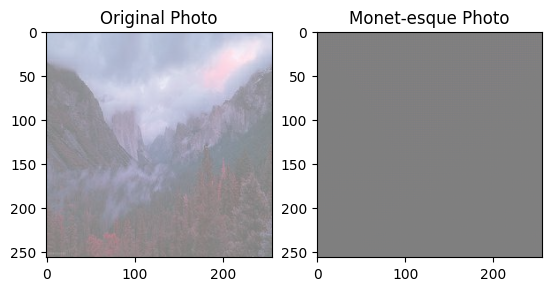

In [55]:
# generate a sample image
generator = make_generator_model()

example_pohto = photo_images.take(1)

# Expand the dimensions to match the model's input shape
example_photo = tf.expand_dims(example_photo, axis=0)

to_monet = generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

In [75]:
from tqdm import tqdm

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

generator = make_generator_model()

discriminator = make_discriminator_model()

checkpoint_path = "./checkpoints"
ckpt = tf.train.Checkpoint(generator=generator,
                           discriminator=discriminator,
                           generator_optimizer=generator_optimizer,
                           discriminator_optimizer=discriminator_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

def resize_image(image):
    # Expand the dimensions to add a batch dimension
    image = tf.expand_dims(image, axis=0)
    # Resize the image to the specified size
    return tf.image.resize(image, [256, 256])

# Training loop
EPOCHS = 25
for epoch in range(EPOCHS):
    # Shuffle the dataset
    photo_images_shuffled = photo_images.shuffle(buffer_size=1000)

    progress_bar = tqdm(enumerate(tf.data.Dataset.zip((photo_images_shuffled, monet_images))), total=len(photo_images_shuffled))


    # Iterate over the shuffled dataset
    for batch_idx, (photo_image, monet_image) in progress_bar:
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            photo_image = tf.expand_dims(photo_image, axis=0)
            
            # Forward pass through the generator
            generated_monet_images = generator(photo_image, training=True)

            # Resize Monet image to match the discriminator input shape
            resized_monet_image = resize_image(monet_image)
            
            # Forward pass through the discriminator
            real_output = discriminator(resized_monet_image, training=True)
            generated_output = discriminator(generated_monet_images, training=True)

            # Compute the losses
            gen_loss = generator_loss(generated_output)
            disc_loss = discriminator_loss(real_output, generated_output)

            # Compute cycle consistency loss
            cycle_loss = calc_cycle_loss(resized_monet_image, generated_monet_images)
            
            # Total generator loss
            total_gen_loss = gen_loss + cycle_loss

        # Compute gradients
        gen_gradients = gen_tape.gradient(total_gen_loss, generator.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # Apply gradients
        generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

        progress_bar.set_description(f'Epoch {epoch+1}, Batch {batch_idx+1}/{len(photo_images_shuffled)}, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}')
    
    # Save checkpoint
    ckpt_manager.save()

    # Print metrics or visualize images periodically
    print(f'Epoch {epoch+1}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}')

Epoch 1, Batch 300/7038, Generator Loss: 0.8414, Discriminator Loss: 0.6166:   4%|█▏                           | 300/7038 [03:18<1:14:07,  1.52it/s]2024-05-03 02:45:52.268785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 1, Generator Loss: 0.8414187431335449, Discriminator Loss: 0.6165862083435059


Epoch 2, Batch 300/7038, Generator Loss: 1.9758, Discriminator Loss: 0.2880:   4%|█▏                           | 300/7038 [03:21<1:15:34,  1.49it/s]2024-05-03 02:49:14.218110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 2, Generator Loss: 1.9758235216140747, Discriminator Loss: 0.28797417879104614


Epoch 3, Batch 300/7038, Generator Loss: 1.4343, Discriminator Loss: 0.6594:   4%|█▏                           | 300/7038 [03:23<1:15:59,  1.48it/s]2024-05-03 02:52:37.315811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 3, Generator Loss: 1.434340238571167, Discriminator Loss: 0.6593876481056213


Epoch 4, Batch 300/7038, Generator Loss: 1.9645, Discriminator Loss: 0.9072:   4%|█▏                           | 300/7038 [03:16<1:18:11,  1.44it/s]2024-05-03 02:55:54.150617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 4, Batch 300/7038, Generator Loss: 1.9645, Discriminator Loss: 0.9072:   4%|█▏                           | 300/7038 [03:16<1:13:39,  1.52it/s]


Epoch 4, Generator Loss: 1.9645400047302246, Discriminator Loss: 0.9071544408798218


Epoch 5, Batch 300/7038, Generator Loss: 4.0088, Discriminator Loss: 0.1239:   4%|█▏                           | 300/7038 [03:20<1:15:08,  1.49it/s]2024-05-03 02:59:14.983098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 5, Generator Loss: 4.008798122406006, Discriminator Loss: 0.123858742415905


Epoch 6, Batch 300/7038, Generator Loss: 2.3920, Discriminator Loss: 0.1511:   4%|█▏                           | 300/7038 [03:20<1:15:57,  1.48it/s]2024-05-03 03:02:35.968284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 6, Batch 300/7038, Generator Loss: 2.3920, Discriminator Loss: 0.1511:   4%|█▏                           | 300/7038 [03:20<1:15:11,  1.49it/s]


Epoch 6, Generator Loss: 2.392001152038574, Discriminator Loss: 0.15108098089694977


Epoch 7, Batch 300/7038, Generator Loss: 4.2279, Discriminator Loss: 0.3944:   4%|█▏                           | 300/7038 [03:22<1:19:29,  1.41it/s]2024-05-03 03:05:59.057664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 7, Batch 300/7038, Generator Loss: 4.2279, Discriminator Loss: 0.3944:   4%|█▏                           | 300/7038 [03:22<1:15:58,  1.48it/s]


Epoch 7, Generator Loss: 4.22792911529541, Discriminator Loss: 0.3944389224052429


Epoch 8, Batch 300/7038, Generator Loss: 3.8674, Discriminator Loss: 0.1822:   4%|█▏                           | 300/7038 [03:20<1:15:03,  1.50it/s]2024-05-03 03:09:19.628555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 8, Generator Loss: 3.867438793182373, Discriminator Loss: 0.1821703016757965


Epoch 9, Batch 300/7038, Generator Loss: 0.7616, Discriminator Loss: 0.5125:   4%|█▏                           | 300/7038 [03:20<1:15:02,  1.50it/s]2024-05-03 03:12:40.227077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 9, Generator Loss: 0.761590838432312, Discriminator Loss: 0.5125088095664978


Epoch 10, Batch 300/7038, Generator Loss: 1.8110, Discriminator Loss: 0.2491:   4%|█▏                          | 300/7038 [03:21<1:15:32,  1.49it/s]2024-05-03 03:16:02.137642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 10, Generator Loss: 1.8109958171844482, Discriminator Loss: 0.2491265833377838


Epoch 11, Batch 300/7038, Generator Loss: 2.4142, Discriminator Loss: 0.0852:   4%|█▏                          | 300/7038 [03:18<1:14:25,  1.51it/s]2024-05-03 03:19:21.052140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 11, Generator Loss: 2.414151191711426, Discriminator Loss: 0.08515147119760513


Epoch 12, Batch 300/7038, Generator Loss: 2.3481, Discriminator Loss: 0.0824:   4%|█▏                          | 300/7038 [03:11<1:11:59,  1.56it/s]2024-05-03 03:22:32.635528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 12, Batch 300/7038, Generator Loss: 2.3481, Discriminator Loss: 0.0824:   4%|█▏                          | 300/7038 [03:11<1:11:41,  1.57it/s]


Epoch 12, Generator Loss: 2.348125457763672, Discriminator Loss: 0.08238735795021057


Epoch 13, Batch 300/7038, Generator Loss: 5.0706, Discriminator Loss: 0.0759:   4%|█▏                          | 300/7038 [03:19<1:14:35,  1.51it/s]2024-05-03 03:25:51.956159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 13, Generator Loss: 5.070578098297119, Discriminator Loss: 0.07594035565853119


Epoch 14, Batch 300/7038, Generator Loss: 3.7830, Discriminator Loss: 0.0586:   4%|█▏                          | 300/7038 [03:22<1:15:41,  1.48it/s]2024-05-03 03:29:14.239472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 14, Generator Loss: 3.7830302715301514, Discriminator Loss: 0.05858943983912468


Epoch 15, Batch 300/7038, Generator Loss: 4.1690, Discriminator Loss: 0.0871:   4%|█▏                          | 300/7038 [03:09<1:10:56,  1.58it/s]2024-05-03 03:32:23.840259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 15, Generator Loss: 4.1689653396606445, Discriminator Loss: 0.0871436595916748


Epoch 16, Batch 300/7038, Generator Loss: 1.4500, Discriminator Loss: 0.2486:   4%|█▏                          | 300/7038 [03:11<1:11:48,  1.56it/s]2024-05-03 03:35:35.757134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 16, Generator Loss: 1.450016736984253, Discriminator Loss: 0.24862903356552124


Epoch 17, Batch 300/7038, Generator Loss: 4.2081, Discriminator Loss: 1.4951:   4%|█▏                          | 300/7038 [03:12<1:12:03,  1.56it/s]
2024-05-03 03:38:48.351814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 17, Generator Loss: 4.208069801330566, Discriminator Loss: 1.4951316118240356


Epoch 18, Batch 300/7038, Generator Loss: 1.7740, Discriminator Loss: 0.2190:   4%|█▏                          | 300/7038 [03:13<1:11:54,  1.56it/s]2024-05-03 03:42:02.036079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 18, Batch 300/7038, Generator Loss: 1.7740, Discriminator Loss: 0.2190:   4%|█▏                          | 300/7038 [03:13<1:12:28,  1.55it/s]


Epoch 18, Generator Loss: 1.7739571332931519, Discriminator Loss: 0.21897034347057343


Epoch 19, Batch 300/7038, Generator Loss: 2.8459, Discriminator Loss: 0.0892:   4%|█▏                          | 300/7038 [03:13<1:12:30,  1.55it/s]2024-05-03 03:45:15.812548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 19, Generator Loss: 2.8458504676818848, Discriminator Loss: 0.08919014036655426


Epoch 20, Batch 300/7038, Generator Loss: 2.4135, Discriminator Loss: 0.2883:   4%|█▏                          | 300/7038 [03:12<1:12:11,  1.56it/s]2024-05-03 03:48:27.939024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 20, Batch 300/7038, Generator Loss: 2.4135, Discriminator Loss: 0.2883:   4%|█▏                          | 300/7038 [03:12<1:11:53,  1.56it/s]


Epoch 20, Generator Loss: 2.4135305881500244, Discriminator Loss: 0.28825128078460693


Epoch 21, Batch 300/7038, Generator Loss: 0.3181, Discriminator Loss: 0.8885:   4%|█▏                          | 300/7038 [03:12<1:12:08,  1.56it/s]
2024-05-03 03:51:40.745054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 21, Generator Loss: 0.31805312633514404, Discriminator Loss: 0.8885170817375183


Epoch 22, Batch 300/7038, Generator Loss: 4.6446, Discriminator Loss: 0.7196:   4%|█▏                          | 300/7038 [03:10<1:11:24,  1.57it/s]2024-05-03 03:54:51.590675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 22, Generator Loss: 4.6445817947387695, Discriminator Loss: 0.7196047306060791


Epoch 23, Batch 300/7038, Generator Loss: 7.0422, Discriminator Loss: 2.0265:   4%|█▏                          | 300/7038 [03:13<1:12:19,  1.55it/s]2024-05-03 03:58:04.747975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 23, Batch 300/7038, Generator Loss: 7.0422, Discriminator Loss: 2.0265:   4%|█▏                          | 300/7038 [03:13<1:12:16,  1.55it/s]


Epoch 23, Generator Loss: 7.042171478271484, Discriminator Loss: 2.026519775390625


Epoch 24, Batch 300/7038, Generator Loss: 4.8326, Discriminator Loss: 0.4643:   4%|█▏                          | 300/7038 [03:13<1:12:28,  1.55it/s]
2024-05-03 04:01:18.427499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 24, Generator Loss: 4.832632541656494, Discriminator Loss: 0.46432238817214966


Epoch 25, Batch 300/7038, Generator Loss: 4.2303, Discriminator Loss: 0.0253:   4%|█▏                          | 300/7038 [03:12<1:11:59,  1.56it/s]

Epoch 25, Generator Loss: 4.230303764343262, Discriminator Loss: 0.025338128209114075



2024-05-03 04:04:30.819352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Results and Analysis 

This type of task usually involves more visual inspection that quantitative but I tried to include both. I generate some sample images to get a look at what the generator is generating and compare it to the input. I found the generated image to look ok but not perfect.

I also tried to use SSIM and PSNR to give a numeric representation of the closeness of the images. The SSIM is the structural similarity index. It measures the similarity between generated images and real images based on luminance, contrast and structure. The PSNR is the peak signal-to-noise ratio. It measures the likeness of the images based on pixel-wise differences. The higher each number is the more similar they are. Since we are generating an image to a different style of the same image, even if we had a perfect model we would next expect a perfect score for these values. Below are my results for the model:

SSIM: tf.Tensor(
[0.18794239 0.0679956  0.04829047 0.2083137  0.0738501  0.16573483
 0.05246009 0.12985454 0.19332273 0.13821197 0.09441439 0.10754072
 0.0671097  0.25929847 0.15412612 0.11669964 0.11139729 0.06804655
 0.0677081  0.08093754 0.16208047 0.19826    0.26892123 0.1246902
 0.10597348 0.17409597 0.17271642 0.06320092 0.08212952 0.08787853
 0.0932105  0.08874073 0.1505469  0.10277721 0.08081277 0.1144794
 0.13911833 0.08877641 0.08795313 0.07295925 0.18342716 0.1339007
 0.07764428 0.09701516 0.06149835 0.20781307 0.15865232 0.0501559
 0.12130666 0.05988703 0.08864269 0.13737446 0.14937218 0.06434751
 0.09375119 0.06487359 0.11162873 0.09971929 0.09413433 0.13525654
 0.11546686 0.24567886 0.13141222 0.13953643 0.14339148 0.12744175
 0.11340687 0.13747057 0.09902277 0.05507853 0.05790621 0.3601501
 0.05391371 0.10616586 0.07344129 0.1493022  0.06720272 0.1318813
 0.04883762 0.07266387 0.09122965 0.07647445 0.11846714 0.10318062
 0.12968476 0.11266059 0.15564798 0.14521067 0.10356487 0.13055082
 0.04603153 0.09381599 0.10731994 0.13348143 0.11358749 0.1396688
 0.12387198 0.09358236 0.1250306  0.04009623 0.05331996 0.1393417
 0.1629206  0.20655452 0.10174244 0.1111095  0.07028349 0.13999544
 0.11191707 0.11364578 0.13953549 0.13749106 0.09475019 0.10962924
 0.21066594 0.23627634 0.17159994 0.06611273 0.0345493  0.09719503
 0.08666331 0.13361244 0.10469094 0.15013953 0.06361206 0.05578613
 0.20698516 0.19967584 0.14414285 0.14811707 0.11270732 0.05597292
 0.13127907 0.05392774 0.07551938 0.15257736 0.08067843 0.15871507
 0.21806218 0.08675653 0.11503496 0.07476574 0.10207278 0.2655182
 0.12215763 0.1382678  0.09724098 0.1426375  0.18844295 0.14682703
 0.20800824 0.09685641 0.22400264 0.12841555 0.14981312 0.07206506
 0.17551868 0.10684878 0.07731958 0.12769888 0.17482431 0.11160541
 0.13004528 0.10735206 0.07747373 0.23230849 0.09421018 0.12095679
 0.11901292 0.07918402 0.11531552 0.12705906 0.14924945 0.2009324
 0.1350831  0.0712414  0.15192479 0.0849259  0.08639327 0.04338291
 0.10153467 0.13250163 0.18681628 0.11159491 0.06342051 0.03887925
 0.19245972 0.05629826 0.05513425 0.04686269 0.06586253 0.09415025
 0.04967028 0.15286385 0.19172478 0.09619222 0.06115031 0.15181305
 0.10294155 0.03163798 0.1393146  0.06490404 0.17239559 0.09645727
 0.05347881 0.12676752 0.07696533 0.07674021 0.09198152 0.05292173
 0.09712438 0.11921304 0.2849305  0.15151238 0.10760981 0.05357939
 0.08621874 0.24439414 0.13035192 0.17690873 0.31938767 0.0976614
 0.03470497 0.12996967 0.06630585 0.07070384 0.08414054 0.05571557
 0.05793915 0.08804313 0.04817207 0.10797492 0.15302779 0.1553381
 0.12275495 0.1824611  0.18366747 0.18067586 0.18969703 0.04227844
 0.17487155 0.12116057 0.18059064 0.11471687 0.04793488 0.23792319
 0.06205928 0.08436485 0.04627788 0.06356894 0.09634653 0.14273325
 0.08977646 0.05755805 0.11634833 0.17110385 0.09345641 0.24337894
 0.16612971 0.1773072  0.16394109 0.11381954 0.10024012 0.2645515
 0.1354958  0.21331681 0.15720172 0.05503256 0.06943955 0.04413991
 0.10309526 0.07363591 0.06144478 0.06923809 0.05746259 0.21608698
 0.16288675 0.09266936 0.14902557 0.06386613 0.10690688 0.16825841
 0.06295715 0.06448582 0.17624123 0.12951775 0.2646695  0.09726451
 0.21706916 0.12646739 0.23707235 0.07782199 0.10950273 0.0719645
 0.17376779 0.15490763 0.12199032 0.0868167  0.06263287 0.16955113], shape=(300,), dtype=float32)
PSNR: tf.Tensor(
[12.169195   7.747225  12.0394745 11.978163  10.096301  12.090626
  7.985953   7.6290917 11.664325  10.626853  12.169199  11.066654
  8.315658  10.689288  11.104844   7.032341   8.882071   5.556312
  5.086644  10.605303  11.539205  10.815665  12.052893   8.581443
  9.599601  12.334915  12.101911  11.167878  10.692271   9.851183
 10.411631  12.187586  11.493068  11.6786785 10.848972   9.800487
  9.138787  11.450912   8.29342   10.326446   9.936274   9.280773
  7.110232  11.158682   8.333424  11.322987   8.755377  10.656905
  7.694743  10.845225  12.111975   8.771577   9.391064  12.034066
 12.350399  10.501604   9.13843   10.28226    8.977478  11.377417
  7.9313607 11.544464   8.6671915 10.124595   8.660359   8.696306
 11.060122   9.335699  10.4445915  6.6882687 11.505281  10.801008
  7.8467717 12.184208   5.579195  12.336039  10.138593  10.025331
 11.857141   6.2883854  7.430367   7.9780097 11.276721  10.083048
 10.101011   7.0670605 11.223231  10.999953   8.950391  11.33472
  7.9396358 11.834217  12.238109   9.84764   11.396392  12.357225
  8.945959   9.195718   8.144315   9.255439  12.226235  10.42054
 10.733559  11.613908   8.664288  10.059734   8.28713    9.828185
 10.863272  10.904172  10.815201  12.449226  10.046528  10.246365
  8.374252  10.677608   8.764678  10.739115   9.33963   12.399126
  6.631621  10.135737  11.769348  11.174821  11.754198   8.512285
  9.142169  12.742787   9.952884  10.208778   9.737024   8.498618
 10.067095  12.187627  10.418833  10.929483   9.741222  10.913015
 12.480095  10.965031   5.9852962 11.756284  10.065225  13.618104
  9.519578  10.239447  10.91872    9.839866  11.298589   9.417529
  9.786204   9.629875  11.426648   8.393021  12.189227  10.391074
  5.9999256  9.758067  10.806312  11.72698   10.984507   8.017596
  8.678191  12.707511  10.080714  11.645354   8.230508  11.863873
 10.273298   9.926409  11.874806  10.878297  10.465455  14.330613
  8.846253  10.066363  12.385892  10.651619  11.19419   10.453544
  9.275445  10.457193  12.376288   8.64168   10.269759   9.528958
 12.187068   7.685742   9.930986  11.440046  11.485684  10.05764
  7.515197   9.31344    9.901288  10.99229    7.257688  11.150723
  9.884122   8.759735  14.885575  10.326836   9.028387  10.137655
 10.652095   8.487201   8.235574   9.958942  10.523802   7.5904016
 11.950472   8.85664   12.372366   9.772087  11.127695   9.816822
  6.4353647  8.45164    8.448312  11.620851  11.704916   9.786977
  8.910755  11.497247  10.884358  11.446166  10.425422   7.5662103
  6.701753   7.2985344  7.542562   9.867479  10.8190775  9.475198
  6.6012607 10.606878  10.630882   9.320405  12.654514   9.011
  9.81752   10.606019  12.454678   9.482524   9.00194   12.52855
  8.521769  10.085552   8.339094  10.003288  10.556369   8.816671
 12.002701   9.197572   9.300998  11.971267   9.422732  12.407473
 12.250545  12.214707   8.486693  11.008815  10.392673  14.6809635
  9.81227   13.157795  11.4654665 12.533196  11.3623495  7.5639315
  9.674258   7.6434827  9.233469  11.882671   9.516726  11.015669
 11.763268   8.747993  10.889113   6.685353   8.466939  10.475496
  9.1458025  9.069299  14.331158  10.463506  10.626502  11.568816
  9.642122   9.565708  13.104109   8.74091   10.649284  11.066082
 12.324493  10.370211   9.725101  10.219895   6.5244155  9.898459 ], shape=(300,), dtype=float32)

I believe these scores were acceptable but not amazing.

What worked well in this model was increasing the number of convolution layers to grab more and more features. I started with just 2 convolution layers but found that it did not produce great results. I slowly added more convolution layers with more/fewer layers (depending on if it was in the generator or discriminator) to get better results. I iteratively changed the # for the filters and adding layers during my process. Troubleshooting was done the same way, through an iterative process to get better results.

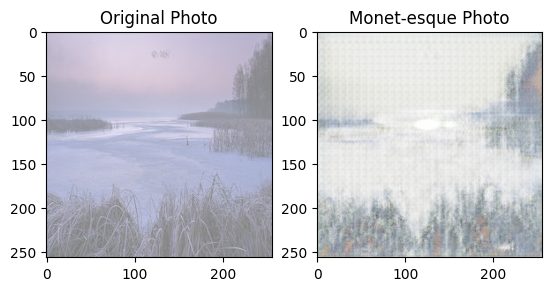

In [81]:
example_photo = next(iter(photo_images))

# Expand the dimensions to match the model's input shape
example_photo = tf.expand_dims(example_photo, axis=0)

to_monet = generator(example_photo, training=False)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

In [87]:
# Define function to calculate SSIM
def calculate_ssim(img1, img2):
    return tf.image.ssim(img1, img2, max_val=1.0)

# Define function to calculate PSNR
def calculate_psnr(img1, img2):
    return tf.image.psnr(img1, img2, max_val=1.0)

real_images = list(monet_images.as_numpy_iterator())
generated_images = []

# Iterate through the photo_images dataset and generate images
for photo_image in photo_images.take(len(real_images)):
    # Expand the dimensions to match the model's input shape
    photo_image = tf.expand_dims(photo_image, axis=0)

    # Generate a Monet-style image from the photo using the generator model
    generated_monet_image = generator(photo_image, training=False)

    # Append the generated image to the list
    generated_images.append(generated_monet_image[0])  # Remove .numpy()

# Convert lists to TensorFlow tensors
real_images = tf.convert_to_tensor(real_images)
generated_images = tf.convert_to_tensor(generated_images)

# Compute SSIM
ssim_value = calculate_ssim(real_images, generated_images)

# Compute PSNR
psnr_value = calculate_psnr(real_images, generated_images)

# Print the computed metrics
print("SSIM:", ssim_value)
print("PSNR:", psnr_value)


2024-05-03 10:59:47.792513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-03 11:00:11.158325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


SSIM: tf.Tensor(
[0.18794239 0.0679956  0.04829047 0.2083137  0.0738501  0.16573483
 0.05246009 0.12985454 0.19332273 0.13821197 0.09441439 0.10754072
 0.0671097  0.25929847 0.15412612 0.11669964 0.11139729 0.06804655
 0.0677081  0.08093754 0.16208047 0.19826    0.26892123 0.1246902
 0.10597348 0.17409597 0.17271642 0.06320092 0.08212952 0.08787853
 0.0932105  0.08874073 0.1505469  0.10277721 0.08081277 0.1144794
 0.13911833 0.08877641 0.08795313 0.07295925 0.18342716 0.1339007
 0.07764428 0.09701516 0.06149835 0.20781307 0.15865232 0.0501559
 0.12130666 0.05988703 0.08864269 0.13737446 0.14937218 0.06434751
 0.09375119 0.06487359 0.11162873 0.09971929 0.09413433 0.13525654
 0.11546686 0.24567886 0.13141222 0.13953643 0.14339148 0.12744175
 0.11340687 0.13747057 0.09902277 0.05507853 0.05790621 0.3601501
 0.05391371 0.10616586 0.07344129 0.1493022  0.06720272 0.1318813
 0.04883762 0.07266387 0.09122965 0.07647445 0.11846714 0.10318062
 0.12968476 0.11266059 0.15564798 0.14521067 0.1035

In [93]:
# Directory to save the generated images temporarily before zipping
output_dir = "generated_images"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Generate images
photo_images = photo_images.batch(1)  # Adjust this if you want to process more images at once
with tqdm(total=len(photo_images)) as progress_bar:
    for idx, photo_image in enumerate(photo_images):
        # Ensure the photo image tensor is in the correct format
        generated_image = generator(photo_image, training=False)  # Set training=False to run in inference mode

        # Convert the generated image tensor to a PIL Image and save it
        generated_image = tf.squeeze(generated_image)  # Remove batch dimension
        generated_image = (generated_image * 255).numpy().astype('uint8')  # Scale to [0, 255]
        img = Image.fromarray(generated_image)
        img.save(os.path.join(output_dir, f"generated_image_{idx+1}.jpg"))

        progress_bar.update(1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7038/7038 [08:51<00:00, 13.25it/s]


NameError: name 'zipfile' is not defined

In [95]:
import zipfile

# Zip the generated images
zip_filename = "images.zip"
with zipfile.ZipFile(zip_filename, 'w') as img_zip:
    for filename in os.listdir(output_dir):
        img_zip.write(os.path.join(output_dir, filename), filename)
    print(f"Generated images are saved and zipped in {zip_filename}")

Generated images are saved and zipped in images.zip


In [92]:
# # Define your models and optimizers as previously described
# generator_g = make_generator_model()  # Generator for Photo to Monet
# generator_f = make_generator_model()  # Generator for Monet to Photo (Reverse Generator)

# discriminator_x = make_discriminator_model()  # Discriminator for real vs generated photos
# discriminator_y = make_discriminator_model()  # Discriminator for real vs generated Monet paintings

# # Define separate optimizers for each generator and discriminator
# generator_g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
# generator_f_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
# discriminator_x_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
# discriminator_y_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# # Checkpointing setup
# checkpoint_path = "./checkpoints-cycle"
# ckpt = tf.train.Checkpoint(generator_g=generator_g,
#                            generator_f=generator_f,
#                            discriminator_x=discriminator_x,
#                            discriminator_y=discriminator_y,
#                            generator_g_optimizer=generator_g_optimizer,
#                            generator_f_optimizer=generator_f_optimizer,
#                            discriminator_x_optimizer=discriminator_x_optimizer,
#                            discriminator_y_optimizer=discriminator_y_optimizer)
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# # Load the latest checkpoint if it exists
# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print("Restored from {}".format(ckpt_manager.latest_checkpoint))
# else:
#     print("Initializing from scratch.")

# # Training loop
# EPOCHS = 25
# for epoch in range(EPOCHS):
#     photo_images_shuffled = photo_images.shuffle(buffer_size=1000).batch(1)
#     monet_images_shuffled = monet_images.shuffle(buffer_size=1000).batch(1)

#     progress_bar = tqdm(tf.data.Dataset.zip((photo_images_shuffled, monet_images_shuffled)), total=len(photo_images))

#     for batch_idx, (photo_image, monet_image) in enumerate(progress_bar):
#         with tf.GradientTape(persistent=True) as tape:
#             fake_monet = generator_g(photo_image, training=True)
#             cycled_photo = generator_f(fake_monet, training=True)

#             fake_photo = generator_f(monet_image, training=True)
#             cycled_monet = generator_g(fake_photo, training=True)

#             disc_real_monet = discriminator_y(monet_image, training=True)
#             disc_fake_monet = discriminator_y(fake_monet, training=True)
#             disc_real_photo = discriminator_x(photo_image, training=True)
#             disc_fake_photo = discriminator_x(fake_photo, training=True)

#             # Calculate the generator and discriminator losses
#             gen_g_loss = generator_loss(disc_fake_monet)
#             gen_f_loss = generator_loss(disc_fake_photo)
#             total_cycle_loss = calc_cycle_loss(monet_image, cycled_monet) + calc_cycle_loss(photo_image, cycled_photo)

#             total_gen_g_loss = gen_g_loss + total_cycle_loss
#             total_gen_f_loss = gen_f_loss + total_cycle_loss

#             disc_x_loss = discriminator_loss(disc_real_photo, disc_fake_photo)
#             disc_y_loss = discriminator_loss(disc_real_monet, disc_fake_monet)

#         # Apply the gradients to the optimizers
#         generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
#         generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))

#         generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
#         generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

#         discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
#         discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))

#         discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
#         discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

#         progress_bar.set_description(f'Epoch {epoch+1}, Batch {batch_idx+1}/{len(photo_images)}, Generator G Loss: {gen_g_loss:.4f}, Generator F Loss: {gen_f_loss:.4f}, Discriminator X Loss: {disc_x_loss:.4f}, Discriminator Y Loss: {disc_y_loss:.4f}')

#     # Save checkpoint at the end of each epoch
#     ckpt_manager.save()
#     print(f'Epoch {epoch+1}, Generator G Loss: {total_gen_g_loss.numpy()}, Generator F Loss: {total_gen_f_loss.numpy()}, Discriminator X Loss: {disc_x_loss.numpy()}, Discriminator Y Loss: {disc_y_loss.numpy()}')

Initializing from scratch.


Epoch 1, Batch 62/7038, Generator G Loss: 2.5612, Generator F Loss: 2.3047, Discriminator X Loss: 0.3527, Discriminator Y Loss: 0.2867:   1%| | 62/7


KeyboardInterrupt: 

Conclusion

The result of this process was that I was able to create a GAN model that was able to produce reasonable generated images in a monet style given a photo input using the architecture described above.

The key learning and takeaways I got from this analysis was how iterative and complex GAN modelling can be. When I tried to build a much more complex model using CycleGAN instead, I quickly found that the training time it would take was way too much for the purpose of this project. What worked well was using a simpler GAN model but adding more convolution layers.

Some suggestions for next time to improve is to experiment more with different architecture. I believe I could have gotten better results by playing around with more layers with a simple GAN model. Using data augmentation techniques or regularization techniques could have probably improved the mdoel's performance. Furthermore, maybe ensembling methods could lead to better results. 